Build network for a single chromosome (c13):

In [73]:
## imports
import numpy as np
from bed_reader import open_bed
import os
from IPython.display import SVG
from sknetwork.embedding import LouvainNE
from sknetwork.visualization import svg_graph, svg_bigraph
from networkx.algorithms import bipartite
from scipy import sparse
from sknetwork.hierarchy import LouvainHierarchy
from sknetwork.hierarchy import cut_straight, dasgupta_score, tree_sampling_divergence
from sknetwork.visualization import svg_graph, svg_bigraph, svg_dendrogram
from sklearn.neighbors import NearestNeighbors
import networkx as nx

In [74]:
## get database workspace
file_name = '/Users/rishasurana/Library/CloudStorage/GoogleDrive-rsurana@usc.edu/.shortcut-targets-by-id/1I-Ssaub3M29w33JyrvO7HVv9laffGidc/chromosome_17_bed_bim_fam_data/ukb22418_c13_b0_v2.bed'


In [75]:
## read bed and select values
bed = open_bed(file_name)
bed.shape
values = bed.read(index=np.s_[0:50,0:50]) ## alter, breaks when length ~100, size must be a perfect square
print(values.shape)
values = np.array(values)
print(values)

(50, 50)
[[2. 0. 2. ... 2. 2. 2.]
 [1. 0. 2. ... 2. 2. 2.]
 [1. 0. 2. ... 1. 2. 2.]
 ...
 [2. 0. 2. ... 2. 2. 2.]
 [2. 0. 1. ... 2. 2. 2.]
 [2. 0. 2. ... 0. 2. 2.]]


In [76]:
## create adjacency matrix
sA = sparse.csr_matrix(values)
G = nx.Graph(sA)
A = nx.adjacency_matrix(G)
AA = A.toarray()
sAA = sparse.csr_matrix(AA)

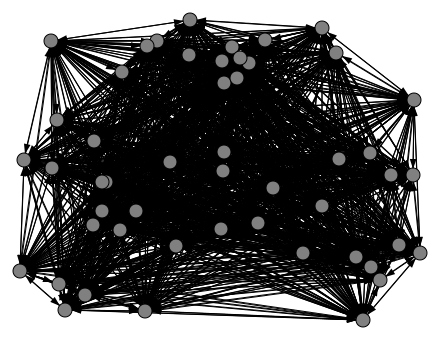

In [77]:
## train classifier and build graph
louvain = LouvainNE(2)
embedding = louvain.fit_transform(sAA)
image = svg_graph(sAA, position=embedding)
SVG(image)